<a href="https://colab.research.google.com/github/tinayiluo0322/XAI_Projects/blob/main/Interpretable_ML_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04
### Interpretable ML II
### Luopeiwen Yi


## Introduction

In this notebook, we will be exploring a heart disease dataset to analyze and predict the likelihood of heart disease in patients using interpretable machine learning models. The dataset, which comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease) and [Kaggle](https://www.kaggle.com/datasets/ketangangal/heart-disease-dataset-uci), contains 1025 observations and 14 features, including attributes such as age, cholesterol levels, and exercise-induced angina. The goal is to predict the presence or absence of heart disease based on these medical indicators.

To build interpretable models for this task, we will be using three distinct models from the `imodels` package, each of which offers interpretability in its own way:
1. **RuleFit**: This model generates a combination of decision tree-based rules (via gradient boosting) and a linear model with Lasso regularization to select the most important rules and features for prediction. It balances model complexity and interpretability by choosing a sparse set of rules that are easy to understand.
   
2. **GreedyRuleListClassifier**: A sequential, rule-based model that creates interpretable decision lists, where each decision path leads to a simple if-then rule. This model is designed to generate compact and interpretable models with high accuracy using a greedy approach.

3. **OptimalTreeClassifier**: This model aims to build optimal decision trees that balance classification accuracy and tree complexity. It has two approaches: GOSDT, which is a globally optimal sparse decision tree algorithm that provides an optimal solution by minimizing error and complexity, and **GreedyTreeClassifier** (CART), which uses a greedy algorithm similar to standard decision trees to find locally optimal splits.

Each of these models will help us not only predict the presence of heart disease but also provide valuable insights into the underlying factors that contribute to the prediction, making the models interpretable and useful in a medical context.


In [227]:
import os

# Remove Colab default sample_data if it exists
if os.path.isdir("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub repo (force re-clone if it already exists)
repo_name = "XAI_Projects"
git_path = 'https://github.com/tinayiluo0322/XAI_Projects.git'

if os.path.isdir(repo_name):
    !rm -rf "{repo_name}"
!git clone "{git_path}"

# Install dependencies from requirements.txt if it exists
#requirements_file = os.path.join(repo_name, 'requirements.txt')
#if os.path.isfile(requirements_file):
    #!pip install -r "{requirements_file}"
#else:
    #print("No requirements.txt found, skipping dependency installation.")

# Change working directory to location of notebook
notebook_dir = 'Interpretable_ML_II'
path_to_notebook = os.path.join(repo_name, notebook_dir)

# Check if the directory exists
if os.path.isdir(path_to_notebook):
    %cd "{path_to_notebook}"
    %ls
else:
    print(f"Directory {path_to_notebook} not found")

Cloning into 'XAI_Projects'...
remote: Enumerating objects: 6105, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 6105 (delta 12), reused 6 (delta 6), pack-reused 6078 (from 1)
Receiving objects: 100% (6105/6105), 96.70 MiB | 23.97 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (5016/5016), done.
/content/XAI_Projects/Interpretable_ML_II/XAI_Projects/Interpretable_ML_II/XAI_Projects/Interpretable_ML_II/XAI_Projects/Interpretable_ML_II/XAI_Projects/Interpretable_ML_II/XAI_Projects/Interpretable_ML_II/XAI_Projects/Interpretable_ML_II
HeartDiseaseTrain-Test.csv  placeholder


In [228]:
!pip install --upgrade imodels scikit-learn --quiet
#!pip3 install attrs packaging editables pandas scikit-learn sortedcontainers gmpy2 matplotlib
#!pip3 install gosdt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imodels import RuleFitClassifier, GreedyRuleListClassifier, OptimalTreeClassifier, GreedyTreeClassifier
#import gosdt
import json
from sklearn.tree import plot_tree, export_text
from sklearn.base import BaseEstimator
from sklearn.utils import validation

from imodels import GreedyTreeClassifier
from imodels.tree.gosdt.pygosdt_helper import TreeClassifier
from imodels.util import rule

try:
    import gosdt

    gosdt_supported = True
except ImportError:
    gosdt_supported = False
#print("GOSDT is installed and ready to use.")

## Exploratory Data Analysis (EDA)


14 attributes per observation in the dataset:

      1. age: age in years  

      2. sex:
         - male
         - female

      3. chest_pain_type:
        - typical angina
        - atypical angina
        - non-anginal pain
        - asymptomatic   

      4. resting_blood_pressure: (in mm Hg on admission to the hospital)

      5. cholestoral: serum cholestoral in mg/dl    

      6. fasting_blood_sugar:
        - Lower than 120 mg/ml
        - Greater than 120 mg/ml

      7. rest_ecg: resting electrocardiographic results
        - Normal
        - ST-T wave abnormality
        - Left ventricular hypertrophy

      8. Max_heart_rate: maximum heart rate achieved

      9. exercise_induced_angina
        - Yes
        - No

      10. oldpeak: ST depression induced by exercise relative to rest

      11. slope: the slope of the peak exercise ST segment
        -- Upsloping
        -- Flat
        -- Downsloping    

      12. vessels_colored_by_flourosopy: number of major vessels (0-3) colored by flourosopy  
        - Zero
        - One
        - Two
        - Three

      13. thalassemia:
        - Normal
        - Fixed defect
        - Reversable Defect  

      14. target: (the predicted attribute) diagnosis of heart disease (angiographic disease status)
        - 0 (No)
        - 1 (Yes)

In [229]:
# URL for the dataset
url = "https://raw.githubusercontent.com/tinayiluo0322/XAI_Projects/refs/heads/main/Interpretable_ML_II/HeartDiseaseTrain-Test.csv"

# Reading the CSV file from the URL and transforming it into a pandas dataframe
df = pd.read_csv(url)

# Displaying the first few rows of the dataframe
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [230]:
# Print out the number of observations and columns
print(f'The dataset contains {df.shape[0]} observations and {df.shape[1]} columns.')

The dataset contains 1025 observations and 14 columns.


In [231]:
# Check for missing values across the entire dataframe
def check_missing_values(df):
    missing_cols = df.columns[df.isna().any()]  # Find columns with any missing values
    if len(missing_cols) > 0:
        print(f'Missing values found in the following columns:\n')
        for column in missing_cols:
            missing_rows = df[df[column].isna()]
            print(f'Column: {column}')
            print(f'Total missing values: {missing_rows.shape[0]}')
            print(f'Rows with missing values in {column}: {missing_rows.index.to_list()}')
            print('-' * 50)
    else:
        print('No missing values found in the dataset.')

# Apply the check on the entire dataframe
check_missing_values(df)

No missing values found in the dataset.


In [232]:
# Set the list of categorical variables and continous variables in the dataset
categorical_vars = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']
continuous_vars = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']

Exploring categorical variable: sex
sex
Male      713
Female    312
Name: count, dtype: int64


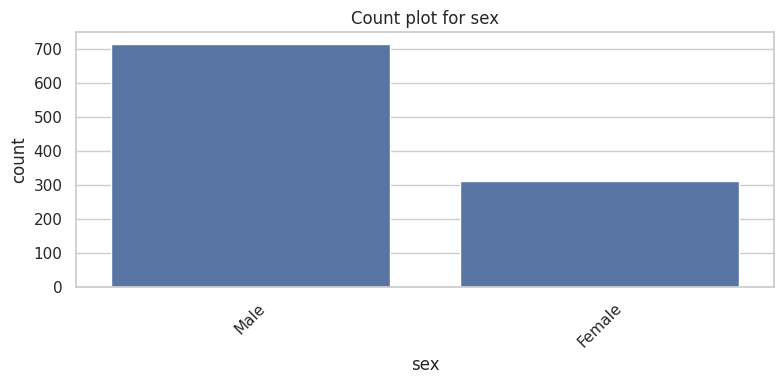

Exploring categorical variable: chest_pain_type
chest_pain_type
Typical angina      497
Non-anginal pain    284
Atypical angina     167
Asymptomatic         77
Name: count, dtype: int64


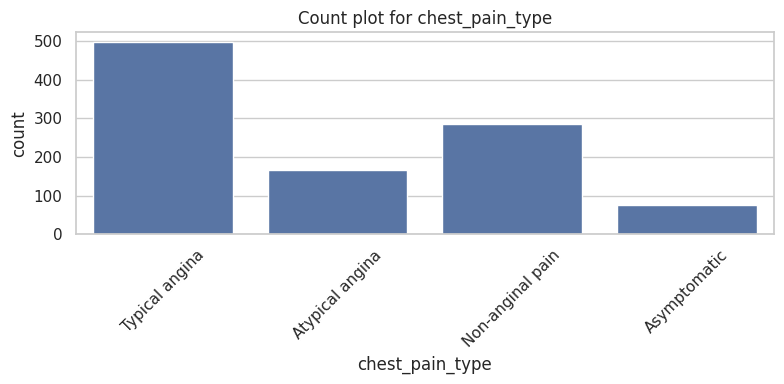

Exploring categorical variable: fasting_blood_sugar
fasting_blood_sugar
Lower than 120 mg/ml      872
Greater than 120 mg/ml    153
Name: count, dtype: int64


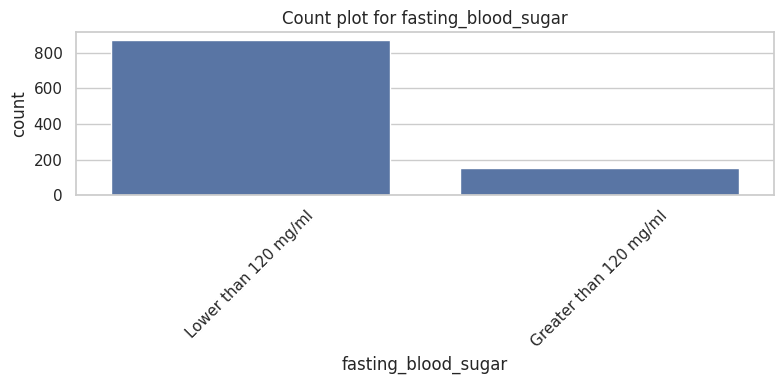

Exploring categorical variable: rest_ecg
rest_ecg
ST-T wave abnormality           513
Normal                          497
Left ventricular hypertrophy     15
Name: count, dtype: int64


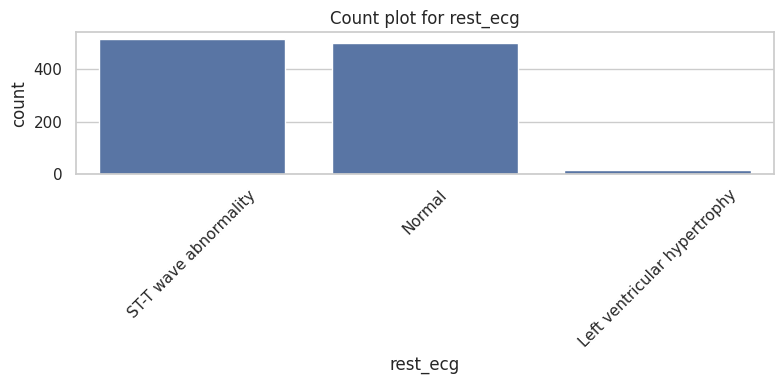

Exploring categorical variable: exercise_induced_angina
exercise_induced_angina
No     680
Yes    345
Name: count, dtype: int64


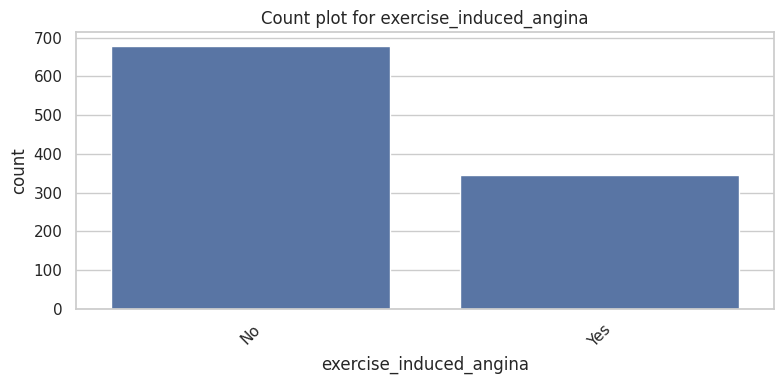

Exploring categorical variable: slope
slope
Flat           482
Downsloping    469
Upsloping       74
Name: count, dtype: int64


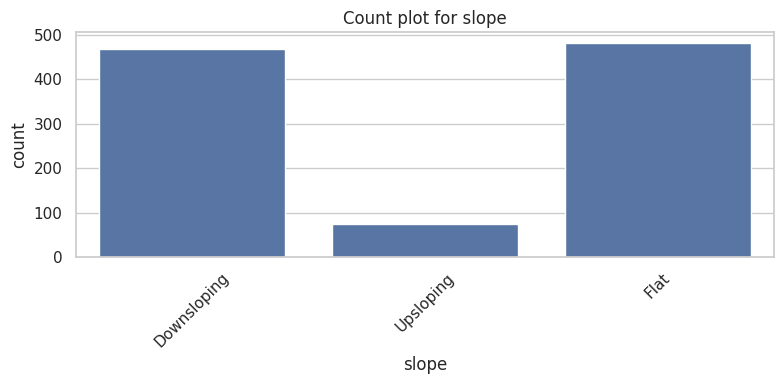

Exploring categorical variable: vessels_colored_by_flourosopy
vessels_colored_by_flourosopy
Zero     578
One      226
Two      134
Three     69
Four      18
Name: count, dtype: int64


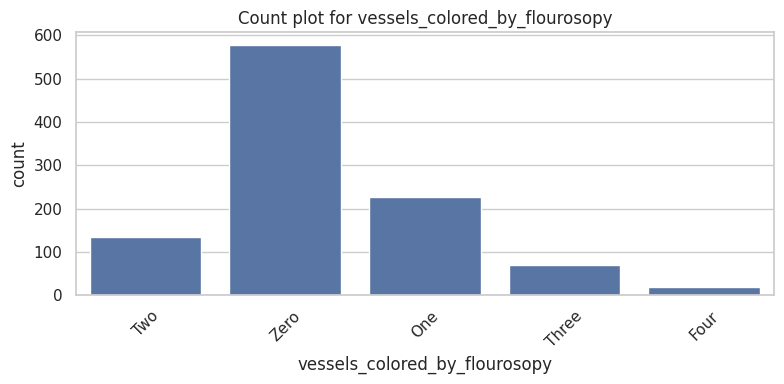

Exploring categorical variable: thalassemia
thalassemia
Fixed Defect         544
Reversable Defect    410
Normal                64
No                     7
Name: count, dtype: int64


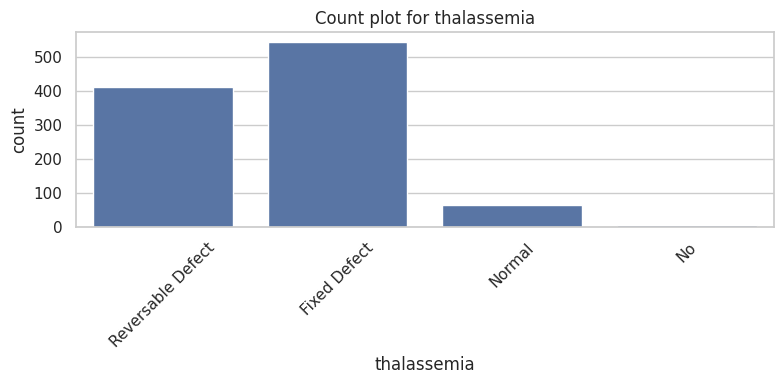


Exploring continuous variable: age


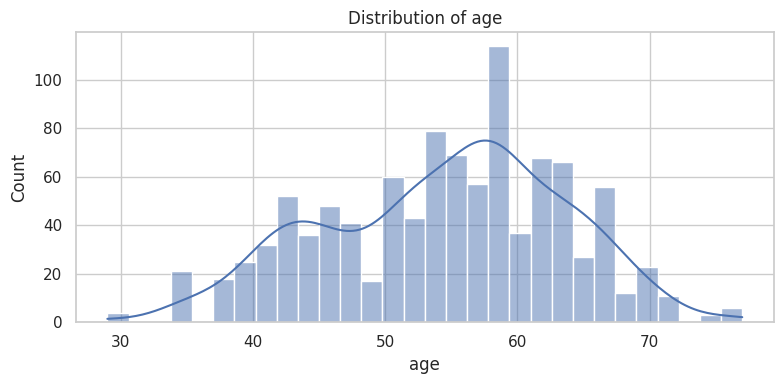


Exploring continuous variable: resting_blood_pressure


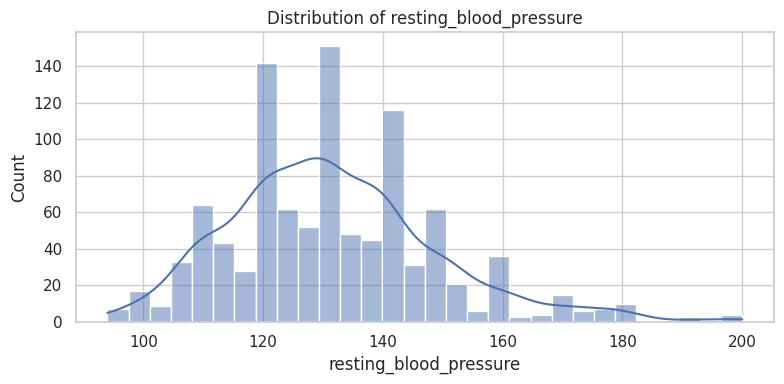


Exploring continuous variable: cholestoral


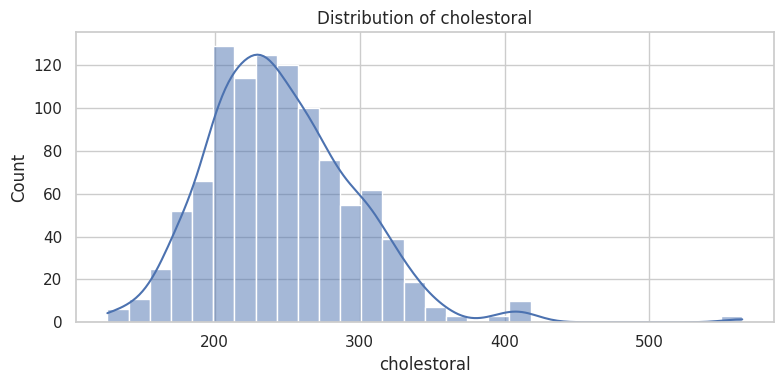


Exploring continuous variable: Max_heart_rate


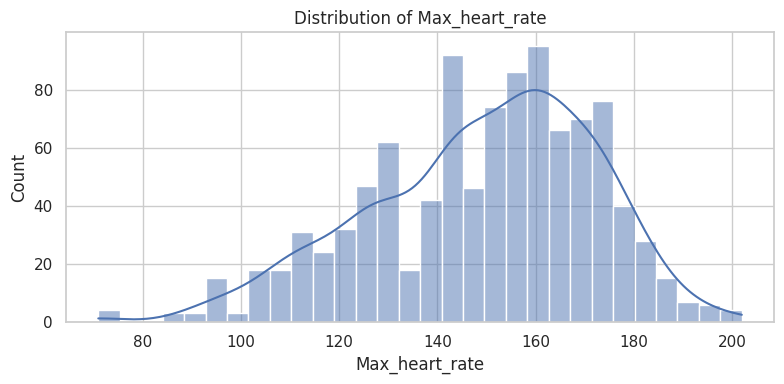


Exploring continuous variable: oldpeak


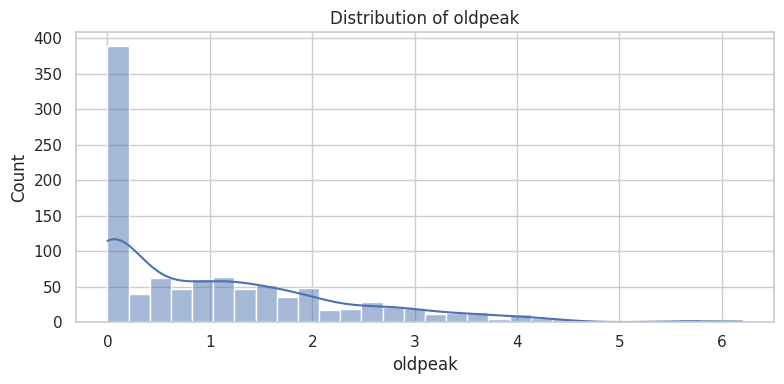

Exploring target outcome variable: Heart Disease
target
1    526
0    499
Name: count, dtype: int64


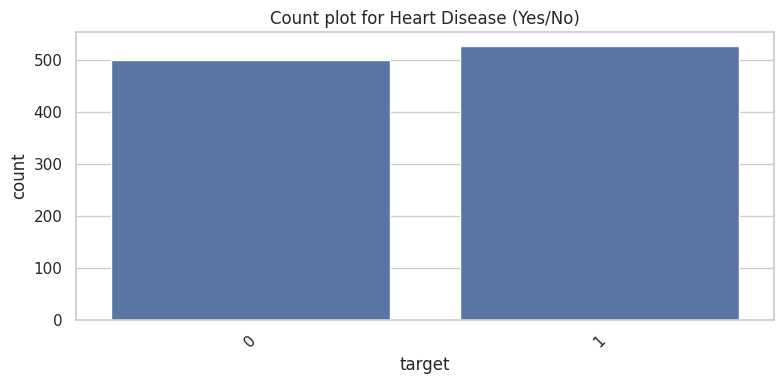

In [233]:
# Set plot style for consistent visualization
sns.set(style="whitegrid")

# Exploring categorical variables
for var in categorical_vars:
    print(f"Exploring categorical variable: {var}")
    print(df[var].value_counts())
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=var)
    plt.title(f'Count plot for {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exploring continuous variables
for var in continuous_vars:
    print(f"\nExploring continuous variable: {var}")
    plt.figure(figsize=(8, 4))
    sns.histplot(df[var].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()

# Exploring target outcome variable (Heart Disease)
print("Exploring target outcome variable: Heart Disease")
print(df['target'].value_counts())
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='target')
plt.title('Count plot for Heart Disease (Yes/No)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [234]:
# One-hot encode the categorical variables, excluding the target variable
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

In [235]:
# print the columns from the one hot encouded data frame
df_encoded.columns

Index(['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate',
       'oldpeak', 'target', 'sex_Male', 'chest_pain_type_Atypical angina',
       'chest_pain_type_Non-anginal pain', 'chest_pain_type_Typical angina',
       'fasting_blood_sugar_Lower than 120 mg/ml', 'rest_ecg_Normal',
       'rest_ecg_ST-T wave abnormality', 'exercise_induced_angina_Yes',
       'slope_Flat', 'slope_Upsloping', 'vessels_colored_by_flourosopy_One',
       'vessels_colored_by_flourosopy_Three',
       'vessels_colored_by_flourosopy_Two',
       'vessels_colored_by_flourosopy_Zero', 'thalassemia_No',
       'thalassemia_Normal', 'thalassemia_Reversable Defect'],
      dtype='object')

In [236]:
# define predictor and target variables
X = df_encoded.drop(columns=['target'])
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RuleFit Model

- [RuleFit Documentation](https://csinva.io/imodels/rule_set/rule_fit.html)
- [RuleFit Source Code on imodel GitHub](https://github.com/csinva/imodels/blob/master/imodels/rule_set/rule_fit.py)

The RuleFit algorithm uses a combination of rules extracted from decision trees (via gradient boosting) and Lasso (L1-regularized linear model) to select the most important rules and linear terms to predict the target variable.

The algorithm can be used for predicting an output vector y given an input matrix X. In the first step a tree ensemble is generated with gradient boosting. The trees are then used to form rules, where the paths to each node in each tree form one rule. A rule is a binary decision if an observation is in a given node, which is dependent on the input features that were used in the splits. The ensemble of rules together with the original input features are then being input in a L1-regularized linear model, also called Lasso, which estimates the effects of each rule on the output target but at the same time estimating many of those effects to zero.

### Key Points

---

### Gradient Boosting Trees:
- The first step is generating a tree ensemble using gradient boosting.
- The paths leading to each node in the trees are transformed into binary rules.
- Each rule represents a decision that depends on the input features.

---

### L1-Regularized Linear Model (Lasso):
- After the rules are extracted, they are combined with the original input features in a linear model.
- Lasso (L1-regularization) is used to penalize and shrink the coefficients of the features and rules, selecting only the most important ones.

---

### Parameters:

- `tree_size`: Number of terminal nodes in generated trees. If `exp_rand_tree_size=True`, this will be the mean number of terminal nodes.
- `sample_fract`: Fraction of randomly chosen training observations used to produce each tree. (FP 2004, Sec. 2)
- `max_rules`: Total number of terms included in the final model (both linear and rules). Approximate total number of candidate rules is based on this.
- `memory_par`: Scale multiplier (shrinkage factor) applied to each new tree when sequentially induced. (FP 2004, Sec. 2)
- `lin_standardise`: If `True`, the linear terms will be standardized (Friedman, Sec. 3.2).
- `lin_trim_quantile`: Quantile used to trim linear terms before standardization (if `lin_standardise=True`).
- `exp_rand_tree_size`: If `True`, each boosted tree will have a different maximum number of terminal nodes based on an exponential distribution around `tree_size`. (Friedman, Sec. 3.3)
- `include_linear`: Include linear terms along with rules.
- `alpha`: Regularization strength, will override `max_rules` parameter.
- `cv`: Whether to use cross-validation scores to select the regularization strength.
- `random_state`: Integer to initialize random objects for repeatability.
- `tree_generator`: Optional. Use a custom tree generator like `GradientBoostingRegressor`, `GradientBoostingClassifier`, or `RandomForestRegressor`.

---

### Linear and Rule-based Models:
- The rules and linear features are combined into a single model, allowing for interpretability.
- The rules are stored in `rules_` and the linear terms are managed via coefficients in `coef`.

---

### Model Fitting and Prediction:
- The `fit` method extracts rules, fits the Lasso model, and computes coefficients for each rule.
- The `predict` method provides predictions based on the fitted rules and linear terms.
- The model supports `predict_proba` for classification tasks, returning class probabilities.

---

### Visualization:
- The class includes a `visualize` method that returns a DataFrame of the rules and their coefficients, sorted by support.


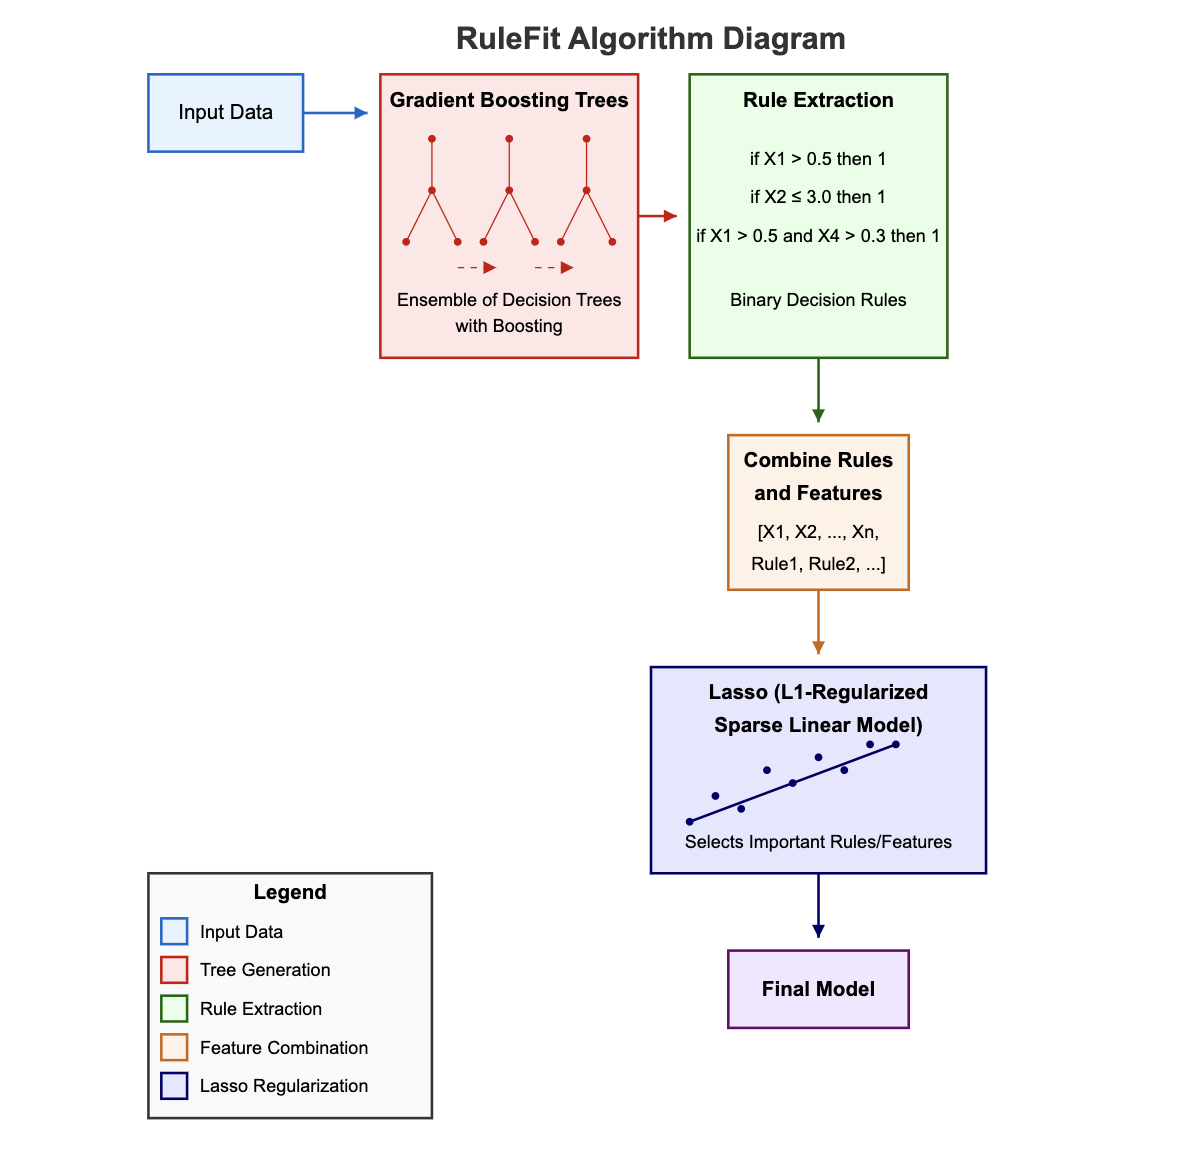

In [237]:
# Initialize the RuleFit
model_rulefit = RuleFitClassifier(random_state=42)

# Train the model
model_rulefit.fit(X_train, y_train)

RuleFitClassifier(random_state=42)

In [238]:
# Get the extracted rules with coefficients and support
#Support: Percentage of data satisfy the rule
#Importance: Measure of how much influnce a model's rule has on model prediction
#importance = abs(coef) * (rule.support * (1 - rule.support)) ** (1 / 2)
rules_df = model_rulefit._get_rules()
rules_df

,rule,type,coef,support,importance
0,age,linear,0.000000,1.000000,0.000000
1,resting_blood_pressure,linear,-0.004771,1.000000,0.080096
2,cholestoral,linear,0.000000,1.000000,0.000000
3,Max_heart_rate,linear,0.000000,1.000000,0.000000
4,oldpeak,linear,0.000000,1.000000,0.000000
5,sex_Male,linear,-0.812583,1.000000,0.372372
6,chest_pain_type_Atypical angina,linear,0.000000,1.000000,0.000000
7,chest_pain_type_Non-anginal pain,linear,0.000000,1.000000,0.000000
8,chest_pain_type_Typical angina,linear,0.000000,1.000000,0.000000
9,fasting_blood_sugar_Lower than 120 mg/ml,linear,0.000000,1.000000,0.000000


In [239]:
# Visualize the rules and coefficients in the model
rule_visualize_df = model_rulefit.visualize()
rule_visualize_df

,rule,coef
1,resting_blood_pressure,-0.00
5,sex_Male,-0.81
13,slope_Flat,-0.66
35,vessels_colored_by_flourosopy_Three <= 0.5 and thalassemia_Reversable Defect <= 0.5 and oldpeak <= 2.1,0.06
34,thalassemia_Reversable Defect <= 0.5 and Max_heart_rate > 120.5 and oldpeak <= 2.45,0.86
29,oldpeak > 0.7,-0.01
39,oldpeak <= 1.95 and chest_pain_type_Typical angina <= 0.5,0.89
41,vessels_colored_by_flourosopy_Zero > 0.5 and cholestoral <= 272.0,0.65
30,vessels_colored_by_flourosopy_Zero > 0.5 and cholestoral <= 272.5,0.57
36,vessels_colored_by_flourosopy_Zero > 0.5 and Max_heart_rate > 147.5,0.15


### RuleFit Model Interpretability Analysis

The RuleFit model produces rules (decision paths) and their corresponding coefficients that influence the probability of an event, in this case, the presence or absence of heart disease. Below is a breakdown of the results with respect to how these rules affect the odds of heart disease using the provided structure, **"If all conditions of the decision rule 𝑟𝑘 apply, the odds for event (heart disease) vs. no-event (No heart disease) changes by a factor of 𝛼𝑘."**

#### General Structure Explanation
Each rule is a condition or set of conditions on one or more features. The coefficient (𝛼𝑘) associated with each rule can be interpreted as follows:
- A positive coefficient means that satisfying the rule increases the odds of having heart disease.
- A negative coefficient means that satisfying the rule decreases the odds of having heart disease.
- A coefficient close to zero has little to no effect on the odds.

#### Detailed Rule Analysis

1. **Rule 1: Resting Blood Pressure (Coef: -0.00)**  
   If the resting blood pressure condition holds, the effect on the odds of heart disease is negligible due to the very small coefficient (-0.00).

2. **Rule 5: Sex (Male) (Coef: -0.81)**  
   Being male decreases the odds of having heart disease by a factor of 0.81 (e^(-0.81)).

3. **Rule 13: Slope (Flat) (Coef: -0.66)**  
   Having a flat slope on the heart’s response to stress decreases the odds of heart disease by a factor of 0.66.

4. **Rule 35: A Combination of Features (Coef: 0.06)**  
   If all the following are true:
   - Vessels colored by fluoroscopy ≤ 0.5
   - Thalassemia (Reversible Defect) ≤ 0.5
   - Oldpeak ≤ 2.1  
   The odds of heart disease increase slightly by a factor of 1.06.

5. **Rule 34: Max Heart Rate, Thalassemia, Oldpeak (Coef: 0.86)**  
   If Max Heart Rate > 120.5, Thalassemia (Reversible Defect) ≤ 0.5, and Oldpeak ≤ 2.45, the odds of heart disease increase by a factor of about 2.36 (e^(0.86)).

6. **Rule 29: Oldpeak > 0.7 (Coef: -0.01)**  
   A slight increase in Oldpeak has a negligible effect on decreasing the odds of heart disease (factor of ~1.00 due to a small negative coefficient).

7. **Rule 39: Oldpeak ≤ 1.95, Chest Pain Type ≤ 0.5 (Coef: 0.89)**  
   If Oldpeak is less than 1.95 and the chest pain type is not typical angina (≤ 0.5), the odds of heart disease increase by a factor of about 2.43.

8. **Rule 41: Vessels Colored by Fluoroscopy > 0.5, Cholesterol ≤ 272.0 (Coef: 0.65)**  
   A higher number of vessels colored by fluoroscopy and cholesterol ≤ 272.0 increases the odds of heart disease by a factor of 1.92.

9. **Rule 30: Same Rule as 41 but Cholesterol ≤ 272.5 (Coef: 0.57)**  
   A very similar condition with a slightly smaller coefficient, still increasing the odds by a factor of 1.77.

10. **Rule 36: Vessels Colored by Fluoroscopy > 0.5, Max Heart Rate > 147.5 (Coef: 0.15)**  
    This rule slightly increases the odds of heart disease by a factor of about 1.16.

11. **Rule 40: Complex Conditions Including Vessels, Thalassemia, Oldpeak (Coef: 0.48)**  
    If the patient has more vessels colored by fluoroscopy, Thalassemia ≤ 0.5, and Oldpeak ≤ 2.6, the odds increase by a factor of about 1.61.

12. **Rule 42: Similar to 40 but with Cholesterol ≤ 326.0 (Coef: 0.45)**  
    This rule slightly increases the odds by a factor of 1.57.

13. **Rule 24: Oldpeak > 0.7, Chest Pain Type > 0.5 (Coef: -0.21)**  
    A higher Oldpeak combined with chest pain (typical angina) reduces the odds of heart disease by a factor of 0.81.

14. **Rule 27: Oldpeak > 0.75, Chest Pain Type > 0.5 (Coef: -0.39)**  
    Similar to Rule 24 but with slightly higher Oldpeak, reducing the odds further by a factor of 0.68.

15. **Rule 46: Max Heart Rate > 152.5, Oldpeak ≤ 1.7, Chest Pain Type ≤ 0.5 (Coef: 0.16)**  
    This rule increases the odds slightly by a factor of 1.17.

16. **Rule 37: Age ≤ 60.5, Thalassemia ≤ 0.5, Max Heart Rate > 152.5 (Coef: 0.06)**  
    A combination of being younger, Thalassemia ≤ 0.5, and high Max Heart Rate slightly increases the odds by a factor of 1.06.

17. **Rule 23: Thalassemia > 0.5, Oldpeak > 0.55 (Coef: -0.60)**  
    Thalassemia and Oldpeak being high reduces the odds of heart disease by a factor of 0.55.

18. **Rule 26: Vessels ≤ 0.5, Oldpeak > 0.55 (Coef: -0.01)**  
    Negligible effect on the odds of heart disease due to a small coefficient.

19. **Rule 22: Vessels ≤ 0.5, Chest Pain Type > 0.5 (Coef: -0.71)**  
    This rule decreases the odds significantly by a factor of 0.49.

20. **Rule 43: Age ≤ 56.5, Max Heart Rate > 150.5, Chest Pain Type ≤ 0.5 (Coef: 0.86)**  
    Increases the odds by a factor of about 2.36.

21. **Rule 28: Resting BP > 115.0, Exercise Induced Angina, Vessels > 0.5 (Coef: -0.63)**  
    Decreases the odds by a factor of 0.53.

22. **Rule 44: Vessels > 0.5, Thalassemia ≤ 0.5, Max Heart Rate > 119.5, Chest Pain Type > 0.5 (Coef: 0.07)**  
    A slight increase in the odds by a factor of 1.07.

23. **Rule 38: Similar to Rule 44 with a higher Max Heart Rate (Coef: 0.21)**  
    Increases the odds by a factor of 1.23.

24. **Rule 32: Similar to Rule 38 but with Oldpeak ≤ 0.7 (Coef: 0.06)**  
    Increases the odds slightly by a factor of 1.06.

25. **Rule 31: Age > 41.5, Vessels > 0.5, Thalassemia > 0.5, Max Heart Rate > 144.5 (Coef: 0.49)**  
    Increases the odds by a factor of 1.63.

26. **Rule 25: BP > 109, Slope ≤ 0.5, Vessels ≤ 0.5, Chest Pain > 0.5 (Coef: -0.55)**  
    Decreases the odds by a factor of 0.58.

27. **Rule 33: Rest ECG ≤ 0.5, Vessels ≤ 0.5, Oldpeak ≤ 0.55 (Coef: 0.77)**  
    Increases the odds by a factor of about 2.16.

28. **Rule 45: Age > 51, No Exercise-Induced Angina, Vessels > 0.5, Thalassemia > 0.5 (Coef: 0.13)**  
    Slightly increases the odds by a factor of 1.14.

#### Conclusion
The model provides insight into how different features interact with each other to affect the likelihood of heart disease. Factors like high Max Heart Rate, low Oldpeak, and specific chest pain types generally increase the odds of heart disease, while other features such as Thalassemia, higher resting blood pressure, and fewer vessels colored by fluoroscopy tend to reduce the odds. Each rule provides an interpretable path, with positive coefficients indicating increased odds and negative ones showing decreased odds.


In [240]:
# Predict class labels. For classification, this returns discrete output (class labels)
y_test_pred = model_rulefit.predict(X_test)

# Predict probabilities for AUC and ROC. For classification tasks, provides class probabilities
y_test_pred_proba = model_rulefit.predict_proba(X_test)[:, 1]  # Use probability for class 1

Test Accuracy: 0.8097560975609757
Test Precision: 0.8333333333333334
Test Recall: 0.7766990291262136
Test F1 Score: 0.8040201005025126
Test AUC: 0.9229011993146773


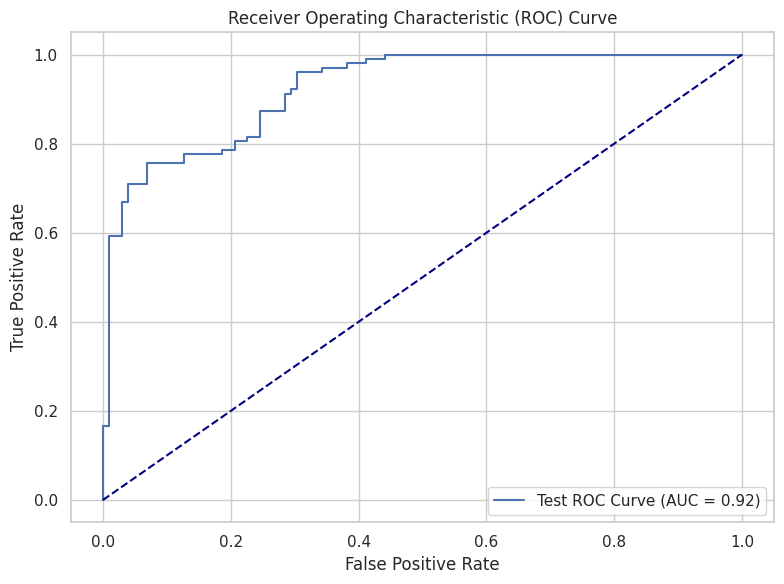

In [241]:
# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print metrics
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC: {test_auc}")

# Plot ROC curve for Test set
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Greedy Rule List

- [Greedy Rule List Documentation](https://csinva.io/imodels/rule_list/greedy_rule_list.html)
- [Greedy Rule List Source Code on imodel GitHub](https://github.com/csinva/imodels/blob/master/imodels/rule_list/greedy_rule_list.py)

The **GreedyRuleListClassifier** is a custom classifier that generates a decision rule list by greedily splitting on one feature at a time, similar to a decision tree. Its primary goal is to maximize the probability of predicting class 1 (binary classification) while building a list of interpretable rules for classification.

---

### Key Concepts

#### 1. Greedy Splitting:
- The classifier works by greedily selecting the best feature to split on at each step.
- It maximizes a chosen criterion (`gini`, `entropy`, or `neg_correlation`), similar to decision trees.
- The depth of the rule list is controlled by the `max_depth` parameter.

#### 2. Recursive Rule Generation:
- The core logic for building the rule list lies in the `fit_node_recursive` method.
- The dataset is split into two groups (left and right) based on the best feature and its cutoff value.
- Rules are created recursively until one of the stopping conditions is met.

#### 3. Stopping Conditions:
The recursion halts under the following conditions:
- **No Data**: If a subset contains no data, it returns an empty rule.
- **Homogeneous Class**: If all the target values (y) in a subset are the same, the rule list stops and returns that class (either 0 or 1).
- **Max Depth**: When the specified `max_depth` is reached, the method stops and returns the average target variable as the predicted probability.

#### 4. Flipping Split Groups:
- If the left-hand side group has a higher probability of class 1 than the right-hand side, the groups are flipped. This ensures that the right-hand side always has the higher probability of class 1, maintaining the goal of maximizing the class 1 probability.

---

### Prediction Logic

#### 1. `predict_proba` Method:
- Computes the probabilities for each sample by applying the rules sequentially.
- If a rule condition is met (regular or flipped), the probability associated with that branch is assigned to the sample.

#### 2. `predict` Method:
- Uses the output of `predict_proba` to select the class with the highest probability for each sample.

---

### Splitting Criteria

#### 1. **Gini Criterion** (`_gini_criterion`):
- Measures the impurity of a split. Gini impurity is minimized when most instances in a node belong to a single class.

#### 2. **Entropy Criterion** (`_entropy_criterion`):
- Measures the disorder or uncertainty in a dataset. Lower entropy indicates a more homogeneous group.

#### 3. **Negative Correlation** (`_neg_corr_criterion`):
- A custom criterion that calculates the negative correlation between the splitting variable and the target variable.
- This criterion is used for binary target variables.

---

### Strengths and Potential Use Cases

- **Simplicity**: The classifier generates an interpretable rule list, making it useful for binary classification tasks where interpretability is important.
- **Customizability**: The classifier supports different splitting criteria (`Gini`, `entropy`, `neg_correlation`), providing flexibility in how splits are evaluated.

---

### Summary

The **GreedyRuleListClassifier** builds a decision rule list by splitting the dataset on one feature at a time. It aims to create simple, interpretable rules that maximize the probability of class 1, making it well-suited for binary classification problems. It allows users to choose different splitting criteria depending on the problem at hand.




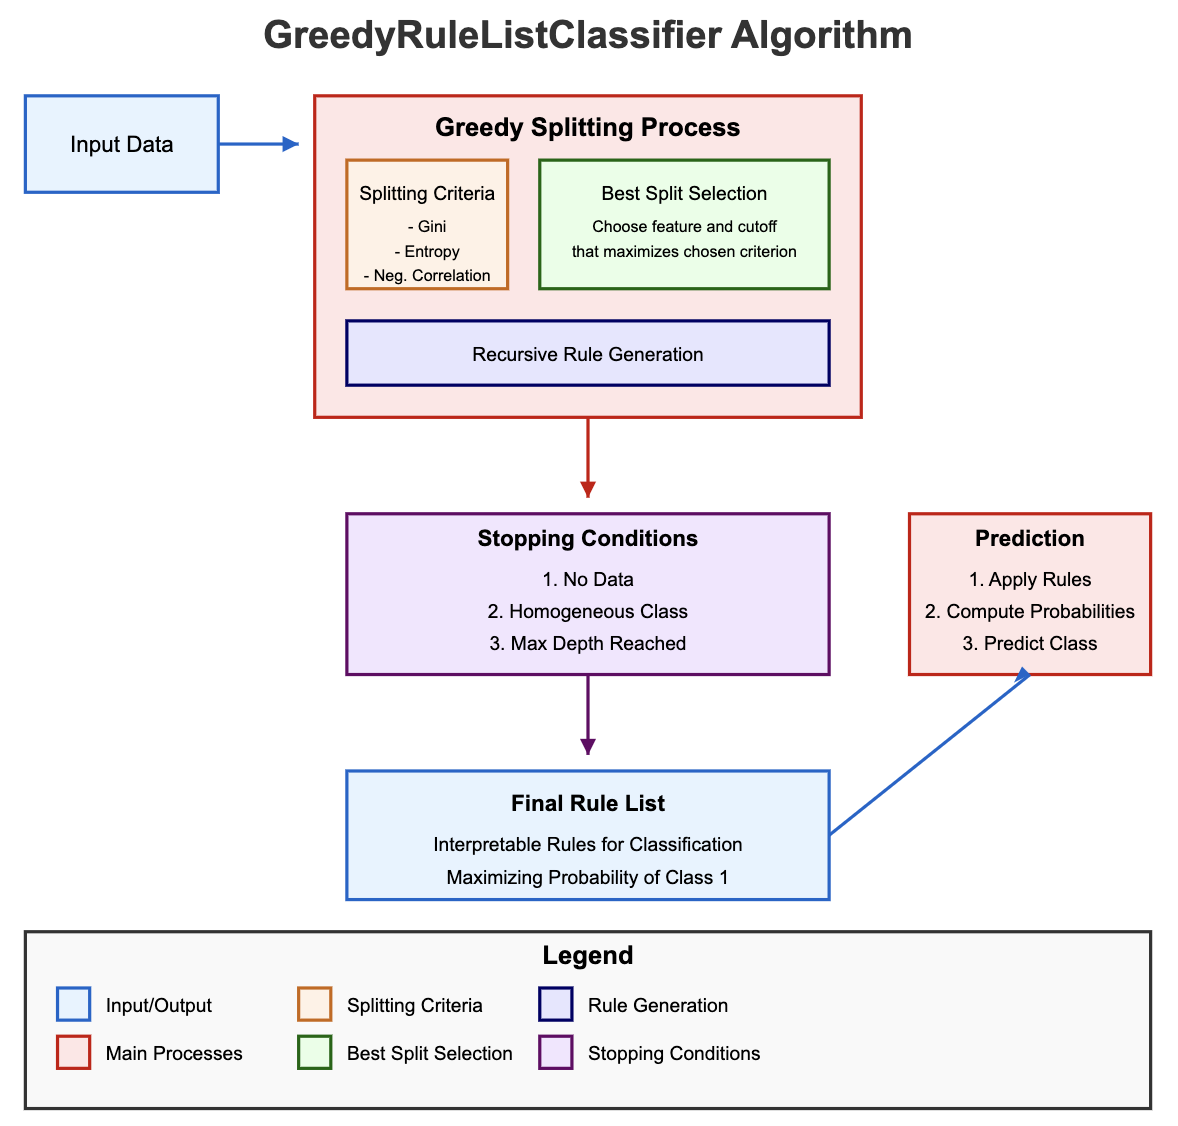

In [242]:
# Initialize the Greedy Rule Tree
model_GreedyRuleList = GreedyRuleListClassifier()

# Train the model
model_GreedyRuleList.fit(X_train, y_train)

[{'col': 'chest_pain_type_Typical angina',
  'index_col': 8,
  'cutoff': 0.5,
  'val': 0.24623115577889448,
  'flip': True,
  'val_right': 0.7701421800947867,
  'num_pts': 820,
  'num_pts_right': 422},
 {'col': 'vessels_colored_by_flourosopy_Zero',
  'index_col': 18,
  'cutoff': 0.5,
  'val': 0.03619909502262444,
  'flip': False,
  'val_right': 0.5084745762711864,
  'num_pts': 398,
  'num_pts_right': 177},
 {'col': 'resting_blood_pressure',
  'index_col': 1,
  'cutoff': 109.0,
  'val': 0.019230769230769232,
  'flip': True,
  'val_right': 0.3076923076923077,
  'num_pts': 221,
  'num_pts_right': 13},
 {'col': 'age',
  'index_col': 0,
  'cutoff': 63.5,
  'val': 0.0,
  'flip': False,
  'val_right': 0.08695652173913043,
  'num_pts': 208,
  'num_pts_right': 46},
 {'val': 0.0, 'num_pts': 162}]

In [243]:
# Visualize the Learnt Rules after training the model
model_GreedyRuleList

GreedyRuleListClassifier()

### Greedy Rule List Classifier Interpretability Analysis

In [244]:
# Access and print each rule in the rule list with values as percentage points
for rule in model_GreedyRuleList.rules_:
    if 'col' in rule:
        print(f"If {rule['col']} >= {rule['cutoff']}, then predict {rule['val_right'] * 100:.2f}% probability of class 1 (heart disease).")
        print(f"Otherwise, predict {rule['val'] * 100:.2f}% probability of class 1 (heart disease).")
    else:
        print(f"If none of the conditions in the previous rules are met, predict {rule['val'] * 100:.2f}% probability (final prediction) of class 1 (heart disease).")

If chest_pain_type_Typical angina >= 0.5, then predict 77.01% probability of class 1 (heart disease).
Otherwise, predict 24.62% probability of class 1 (heart disease).
If vessels_colored_by_flourosopy_Zero >= 0.5, then predict 50.85% probability of class 1 (heart disease).
Otherwise, predict 3.62% probability of class 1 (heart disease).
If resting_blood_pressure >= 109.0, then predict 30.77% probability of class 1 (heart disease).
Otherwise, predict 1.92% probability of class 1 (heart disease).
If age >= 63.5, then predict 8.70% probability of class 1 (heart disease).
Otherwise, predict 0.00% probability of class 1 (heart disease).
If none of the conditions in the previous rules are met, predict 0.00% probability (final prediction) of class 1 (heart disease).


In [245]:
# Make predictions on the test set
y_test_pred = model_GreedyRuleList.predict(X_test)
y_test_pred_proba = model_GreedyRuleList.predict_proba(X_test)[:, 1]  # Get the probability of class 1

Test Accuracy: 0.7122
Test Precision: 0.6486
Test Recall: 0.9320
Test F1 Score: 0.7649
Test AUC: 0.7907


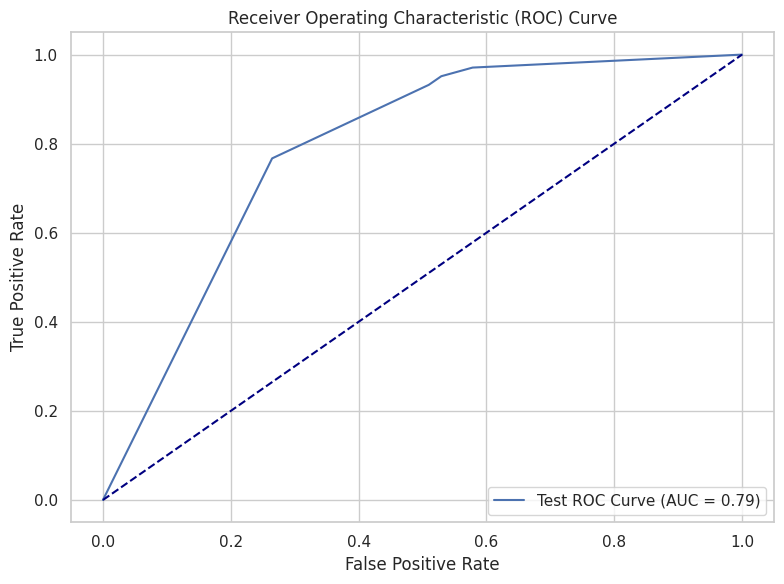

In [246]:
# Evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print evaluation metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Optimal Rule Tree

- [Optimal Rule Tree GOSDT Documentation](https://csinva.io/imodels/tree/gosdt/pygosdt.html#imodels.tree.gosdt.pygosdt.OptimalTreeClassifier)
- [Optimal Rule Tree GOSDT Source Code on imodel GitHub](https://github.com/csinva/imodels/blob/master/imodels/tree/gosdt/pygosdt.py)

In the `OptimalTreeClassifier` class within the `imodels` library, **GOSDT** (Generalized Optimal Sparse Decision Trees) is used to build a decision tree with the goal of creating a globally optimal and sparse tree. The `OptimalTreeClassifier` leverages the branch-and-bound approach of GOSDT to produce trees that are not only accurate but also interpretable and simple by minimizing the number of splits. If GOSDT is not available, this class uses sklearn **GreedyTreeClassifier** as a default approach. The GreedyTreeClassifier is a custom class built on top of DecisionTreeClassifier, which implements the **CART** algorithm.
CART builds decision trees using a greedy strategy, and GreedyTreeClassifier adds a few features like calculating tree complexity and custom tree representation while retaining the CART-based tree-building process.

### GOSDT (Generalized Optimal Sparse Decision Tree) Overview

The **Generalized Optimal Sparse Decision Tree** (GOSDT) algorithm is designed to generate highly interpretable, sparse decision trees while ensuring optimal accuracy and balance between the complexity and performance of the model. GOSDT addresses the common trade-off between interpretability (simple models) and accuracy (complex models) by generating trees that are optimally sparse, meaning fewer nodes and splits.

### Key Concepts of the GOSDT Algorithm

**1. Optimality and Sparsity:**
   - **Optimality** refers to GOSDT’s guarantee of finding the globally optimal decision tree for a given problem based on a defined objective function (e.g., minimizing misclassification error while balancing tree complexity).
   - **Sparsity** ensures the algorithm produces decision trees that are simple, minimizing the number of features and depth of the tree, thus enhancing interpretability.

**2. Formulating the Problem as a Mathematical Optimization:**
   - GOSDT approaches decision tree generation as a **mixed-integer programming** (MIP) problem, optimizing an objective function (e.g., classification accuracy) under constraints to limit tree complexity.
   - The **regularization parameter (λ)** controls the balance between accuracy and sparsity, with higher λ values resulting in simpler trees and lower values allowing more complexity.

**3. Branch-and-Bound Framework:**
   - GOSDT uses **branch-and-bound** to explore possible decision trees. The algorithm evaluates different splits at each node and prunes branches that are unlikely to lead to an optimal solution.
   - This framework allows efficient exploration without needing to evaluate every possible tree.

**4. Pruning and Bounding:**
   - **Bounding** computes upper and lower bounds for each tree split. If a branch’s lower bound is worse than the current best solution, it is pruned to avoid further exploration.
   - Pruning improves efficiency and ensures that only useful branches remain in the final tree.

**5. Look-Ahead Mechanism:**
   - GOSDT’s **look-ahead** feature anticipates future splits while making current decisions, leading to better long-term performance. Unlike CART, which uses a greedy strategy, GOSDT avoids suboptimal early splits by considering future outcomes.

**6. Handling Binary and Continuous Features:**
   - GOSDT handles both **binary (categorical)** and **continuous (numerical)** features. It finds the best threshold for continuous features and evaluates splits based on the presence or absence of binary features.

**7. Efficient Search through Caching and Similar Support:**
   - **Similar support** reduces redundant computations by treating similar data points alike.
   - **Caching** stores intermediate results to further improve the efficiency of the search process.

### Balancing Classification Accuracy and Complexity

GOSDT balances classification accuracy and complexity through an objective function:

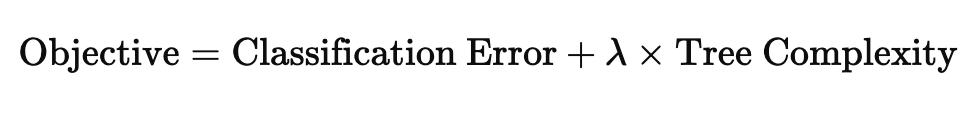
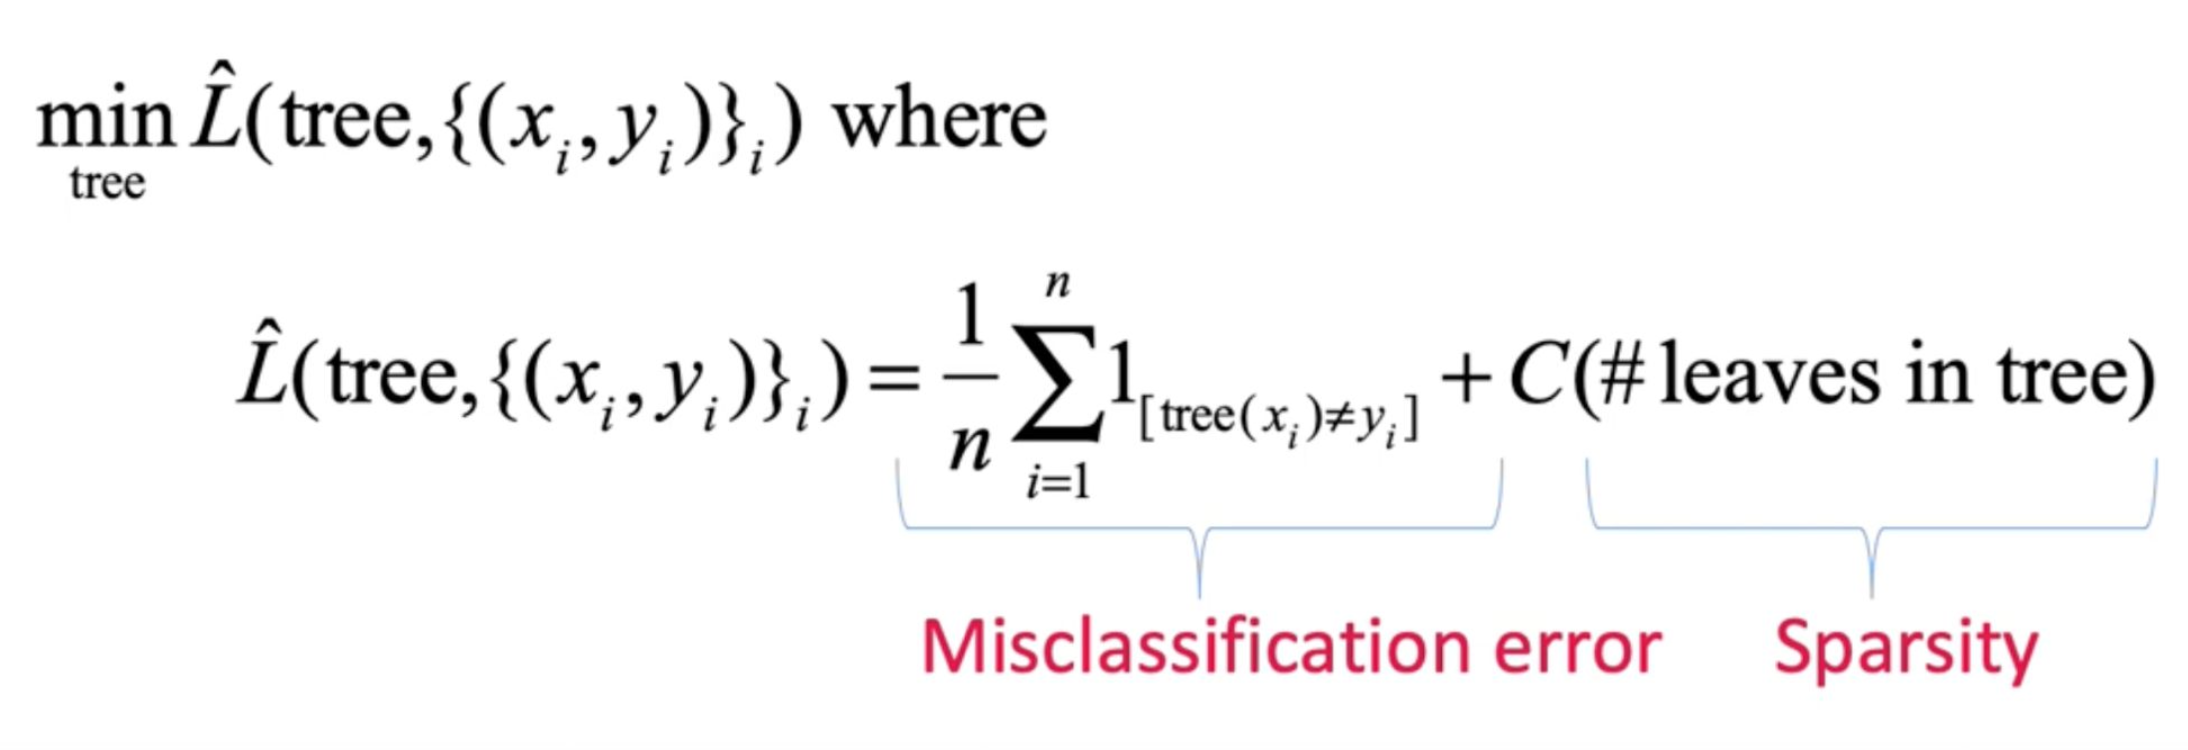

Where:
   - **Classification Error** measures how well the tree performs on the data.
   - **Tree Complexity** measures the depth and number of splits.
   - **λ** is the regularization parameter controlling the trade-off between error and complexity.

### How GOSDT Works

1. **Initialization**:  
   The algorithm starts with a simple decision tree (usually a single node) and calculates bounds for potential trees.
   
2. **Branching**:  
   GOSDT recursively branches on possible feature splits, calculating the objective value for each split.

3. **Bounding and Pruning**:  
   During the branching process, GOSDT tracks the best tree found so far and prunes branches with lower bounds worse than the current best solution.

4. **Recursive Search**:  
   The algorithm continues the recursive search, refining the tree by pruning suboptimal branches until the optimal tree is found or the set limits (e.g., time, depth) are reached.

5. **Final Model**:  
   The output is an optimal, sparse decision tree that balances accuracy and interpretability. Users can tune the regularization parameter (λ) to adjust the trade-off between complexity and performance.


## CART (Classification and Regression Trees) Overview

The **Classification and Regression Trees** (CART) algorithm is a traditional decision tree-building technique used for both classification and regression tasks. It recursively partitions the dataset into subsets based on the feature that results in the best split, with the goal of either classifying the data (in classification) or predicting a continuous target variable (in regression). The tree is built by selecting splits that minimize an objective function (such as Gini impurity or entropy for classification, or mean squared error for regression).

### Key Steps of the CART Algorithm:
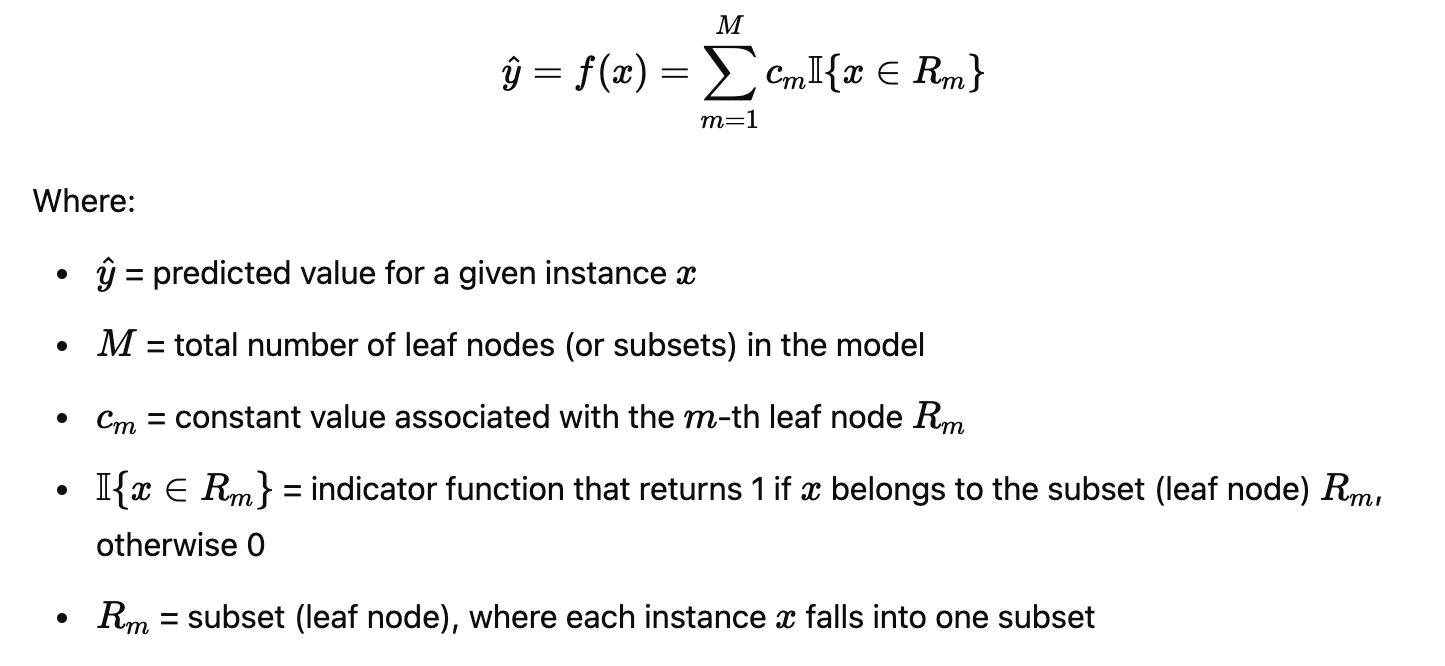


1. **Splitting Criteria:**
   - For classification tasks, CART uses measures like Gini impurity or entropy to evaluate the quality of a split.
   - For regression tasks, CART uses mean squared error (MSE) to determine the quality of the split.
   - The algorithm recursively splits the data on the feature that results in the greatest reduction in the impurity or error.

2. **Greedy Approach:**
   - CART uses a greedy algorithm, meaning it chooses the best possible split at each node without considering future splits. It does not guarantee an optimal solution across the entire tree; it simply looks for locally optimal splits.

3. **Tree Growth:**
   - The tree grows by splitting nodes until certain stopping conditions are met. These conditions might include reaching a maximum tree depth, having a minimum number of samples in a leaf, or achieving perfect classification.

4. **Pruning:**
   - After the tree is fully grown, CART often uses pruning techniques (e.g., cost-complexity pruning) to avoid overfitting. This removes branches of the tree that provide little benefit to the overall accuracy of the model.

5. **Interpretability:**
   - CART produces trees that can be easily interpreted because each split corresponds to a simple if-then rule, making it possible to explain the decision-making process.

### Limitations of CART:
- **Local Optimality:** The greedy nature of CART can lead to suboptimal trees. It only considers the best split at each node, which may not result in the best overall tree.
- **Overfitting:** CART is prone to overfitting, especially when the tree becomes too large and complex. This is why pruning is usually necessary.
- **Lack of Global Optimality:** CART does not guarantee that the final tree is globally optimal in terms of balancing accuracy and complexity.

## Comparison: GOSDT vs CART

| **Feature**                            | **CART**                                                         | **GOSDT**                                                                 |
|----------------------------------------|-------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Splitting Strategy**                 | Greedy approach (local optimality)                                | Branch-and-bound (global optimality)                                      |
| **Regularization**                     | Not built-in (relies on pruning for simplicity)                   | Explicit regularization to control tree sparsity                          |
| **Tree Complexity**                    | Typically more complex, prone to overfitting                      | Sparse trees with a focus on minimizing the number of splits and depth    |
| **Pruning**                            | Done after the tree is fully grown                                | Prunes suboptimal branches during the tree-building process               |
| **Global Optimality**                  | No, the algorithm is greedy                                       | Yes, guarantees globally optimal solutions                                |
| **Handling of Features**               | Supports binary and continuous features                           | Supports binary and continuous features, with optimal threshold selection |
| **Search Method**                      | Greedy, explores splits locally                                   | Branch-and-bound, systematically explores and prunes the search space     |
| **Look-Ahead Mechanism**               | None                                                              | Has a look-ahead mechanism to improve future split decisions              |
| **Computational Efficiency**           | More computationally efficient but suboptimal                     | Less efficient but guarantees the best model with bounding and caching    |
| **Model Interpretability**             | Produces interpretable trees, but they may be complex             | Produces highly interpretable and sparse decision trees                   |

### Key Takeaways:
- **CART** is a greedy algorithm that builds decision trees by choosing the best split at each node without considering the global tree structure. It is prone to overfitting and requires post-processing (pruning) to ensure a balance between accuracy and simplicity. CART trees are often more complex and larger compared to GOSDT.
- **GOSDT** builds globally optimal and sparse trees using a branch-and-bound approach, explicitly controlling tree complexity through regularization. It is more computationally intensive but produces simpler and more interpretable models that are guaranteed to be optimal.



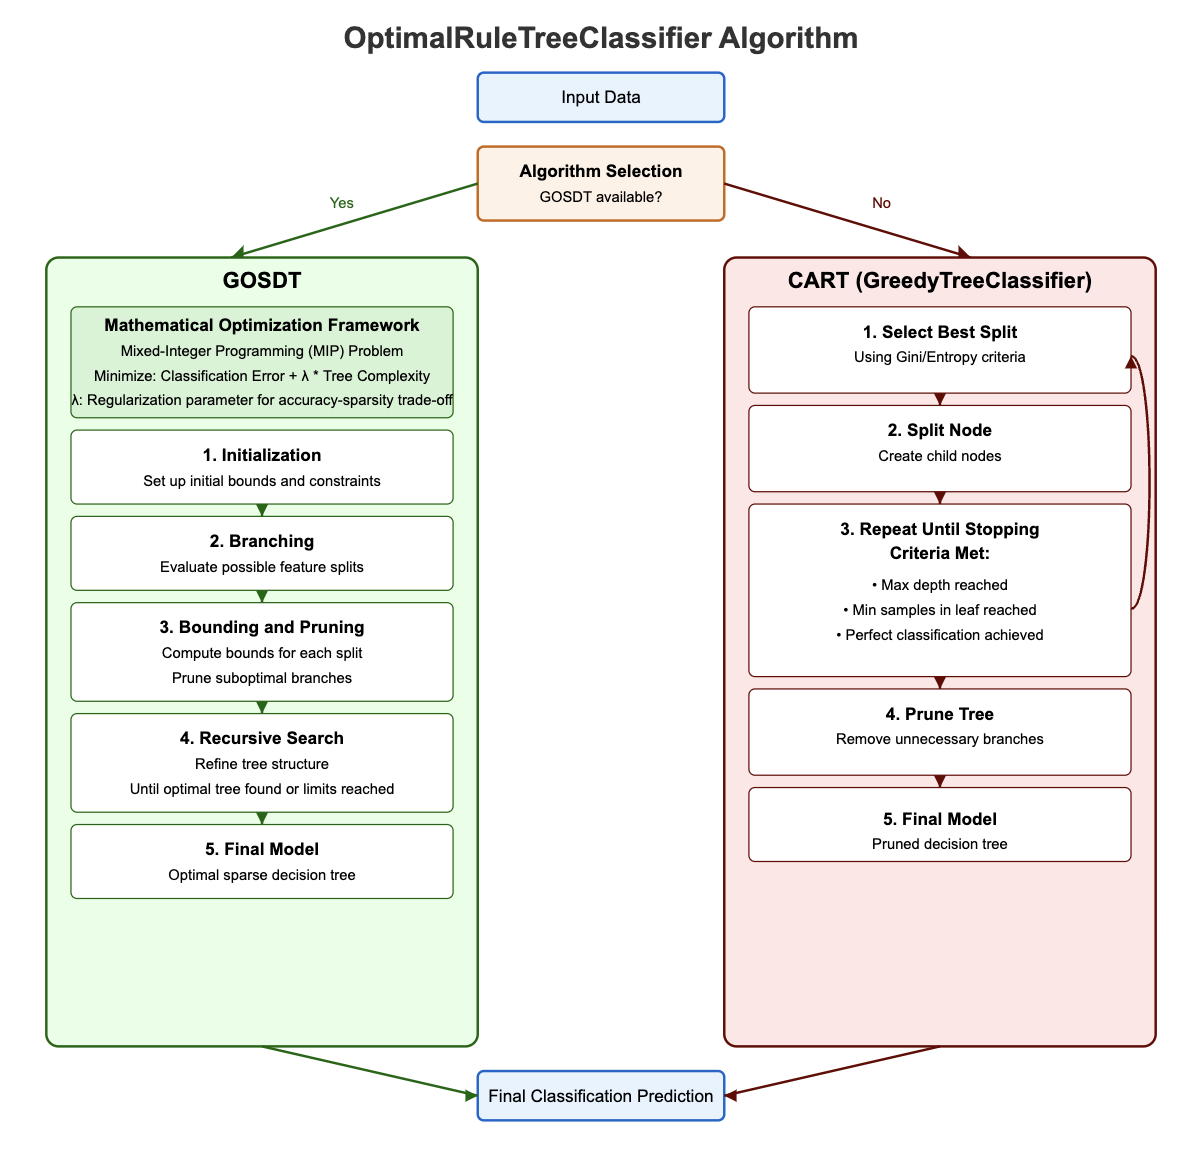

In [247]:
#!pip show gosdt

### Why I’m Using GreedyTreeClassifier Instead of GOSDT for OptimalTreeClassifier

In the original implementation of the `OptimalTreeClassifier` within the `imodels` library, the algorithm has two implementation approaches: **GOSDT** and **GreedyTreeClassifier(CART)**. Due to issues with accessing and configuring the **GOSDT** package in my environment, I have encountered several errors that prevent the seamless use of this method.

These issues include:

- Dependency conflicts when installing the GOSDT library.
- Problems related to the C++ extension required by GOSDT, making it difficult to run in my Jupyter notebook environment.
- Errors such as the inability to access the `gosdt.configure` attribute during model fitting.

Therefore, to ensure that I can complete this assignment and still work with an interpretable decision tree model, I am switching to the **GreedyTreeClassifier(CART)**, which provides a similar approach but does not rely on GOSDT's optimization techniques. The **GreedyTreeClassifier(CART)** builds decision trees using a more straightforward, greedy splitting mechanism, similar to standard decision trees, but it allows me to continue without the technical difficulties caused by GOSDT.

This switch enables me to complete the model training and evaluation process while maintaining the focus on interpretability and performance.


In [248]:
# Modify the original CustomOptimalTreeClassifier function so it's forced to use the GreedyTreeClassifier default setting
class CustomOptimalTreeClassifier(GreedyTreeClassifier):
    def __init__(self,
                 balance=False,
                 cancellation=True,
                 look_ahead=True,
                 similar_support=True,
                 feature_exchange=True,
                 continuous_feature_exchange=True,
                 rule_list=False,
                 diagnostics=False,
                 verbose=False,
                 regularization=0.05,
                 uncertainty_tolerance=0.0,
                 upperbound=0.0,
                 model_limit=1,
                 precision_limit=0,
                 stack_limit=0,
                 tile_limit=0,
                 time_limit=0,
                 worker_limit=1,
                 random_state=None,
                 costs="",
                 model="",
                 profile="",
                 timing="",
                 trace="",
                 tree=""):
        super().__init__()
        self.balance = balance
        self.cancellation = cancellation
        self.look_ahead = look_ahead
        self.similar_support = similar_support
        self.feature_exchange = feature_exchange
        self.continuous_feature_exchange = continuous_feature_exchange
        self.rule_list = rule_list
        self.diagnostics = diagnostics
        self.verbose = verbose
        self.regularization = regularization
        self.uncertainty_tolerance = uncertainty_tolerance
        self.upperbound = upperbound
        self.model_limit = model_limit
        self.precision_limit = precision_limit
        self.stack_limit = stack_limit
        self.tile_limit = tile_limit
        self.time_limit = time_limit
        self.worker_limit = worker_limit
        self.costs = costs
        self.model = model
        self.profile = profile
        self.timing = timing
        self.trace = trace
        self.tree = tree
        self.tree_type = 'dt'
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def load(self, path):
        """
        Parameters
        ---
        path : string
            path to a JSON file representing a model
        """
        with open(path, 'r') as model_source:
            result = model_source.read()
        result = json.loads(result)
        self.tree_ = TreeClassifier(result[0])

    def fit(self, X, y, feature_names=None):
        """
        Parameters
        ---
        X : matrix-like, shape = [n_samples, m_features]
            matrix containing the training samples and features
        y : array-like, shape = [n_samples, 1]
            column containing the correct label for each sample in X

        Modifies
        ---
        trains the model so that this model instance is ready for prediction
        """

        # dtree = DecisionTreeClassifierWithComplexity()
        # dtree.fit(X, y)
        # self.tree_ = dtree
        super().fit(X, y, feature_names=feature_names)
        self.tree_type = 'dt'

        return self

    def predict(self, X):
        """
        Parameters
        ---
        X : matrix-like, shape = [n_samples, m_features]
            a matrix where each row is a sample to be predicted and each column is a feature to
            be used for prediction

        Returns
        ---
        array-like, shape = [n_samples, 1] : a column where each element is the prediction
            associated with each row
        """
        validation.check_is_fitted(self)
        if self.tree_type == 'gosdt':
            if type(self.tree_) is TreeClassifier and not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=self.feature_names_)
            return self.tree_.predict(X)
        else:
            return super().predict(X)

    def predict_proba(self, X):
        validation.check_is_fitted(self)
        if self.tree_type == 'gosdt':
            if type(self.tree_) is TreeClassifier and not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=self.feature_names_)
            probs = np.expand_dims(self.tree_.confidence(X), axis=1)
            return np.hstack((1 - probs, probs))
        else:
            return super().predict_proba(X)

    def score(self, X, y, weight=None):
        """
        Parameters
        ---
        X : matrix-like, shape = [n_samples, m_features]
            an n-by-m matrix of sample and their features
        y : array-like, shape = [n_samples,]
            an n-by-1 column of labels associated with each sample
        weight : shape = [n_samples,]
            an n-by-1 column of weights to apply to each sample's misclassification

        Returns
        ---
        real number : the accuracy produced by applying this model over the given dataset, with
            optionals for weighted accuracy
        """
        validation.check_is_fitted(self)
        if type(self.tree_) is TreeClassifier:
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=self.feature_names_)
            return self.tree_.score(X, y, weight=weight)
        else:
            # Use the score method from the parent class (GreedyTreeClassifier)
            return super().score(X, y, sample_weight=weight)


    def __len__(self):
        """
        Returns
        ---
        natural number : The number of terminal nodes present in this tree
        """
        validation.check_is_fitted(self)
        if type(self.tree_) is TreeClassifier:
            return len(self.tree_)
        else:
            warnings.warn("Using DecisionTreeClassifier due to absence of gosdt package. "
                          "DecisionTreeClassifier does not have this method.")
            return None

    def leaves(self):
        """
        Returns
        ---
        natural number : The number of terminal nodes (leaves) present in this tree
        """
        validation.check_is_fitted(self)
        if hasattr(self, 'tree_') and hasattr(self.tree_, 'get_n_leaves'):  # Ensure the sklearn method exists
            return self.tree_.get_n_leaves()  # Use sklearn's get_n_leaves method
        else:
            warnings.warn("GreedyTreeClassifier does not support this method or tree is not initialized.")
            return None

    def nodes(self):
        """
        Returns
        ---
        natural number : The number of nodes present in this tree
        """
        validation.check_is_fitted(self)
        if type(self.tree_) is TreeClassifier:
            return self.tree_.nodes()
        else:
            warnings.warn("Using DecisionTreeClassifier due to absence of gosdt package. "
                          "DecisionTreeClassifier does not have this method.")
            return None

    def max_depth(self):
        """
        Returns
        ---
        natural number : the length of the longest decision path in this tree (using sklearn method)
        """
        validation.check_is_fitted(self)
        if hasattr(self, 'tree_') and hasattr(self.tree_, 'tree_'):  # Check if the tree_ attribute exists and is a valid tree
            return self.tree_.get_depth()  # Use sklearn's get_depth method to calculate the depth
        else:
            warnings.warn("Tree is not properly initialized or GreedyTreeClassifier does not support this method.")
            return None

    def latex(self):
        """
        Note
        ---
        This method doesn't work well for label headers that contain underscores due to underscore
            being a reserved character in LaTeX

        Returns
        ---
        string : A LaTeX string representing the model
        """
        validation.check_is_fitted(self)
        if type(self.tree_) is TreeClassifier:
            return self.tree_.latex()
        else:
            warnings.warn("Using DecisionTreeClassifier due to absence of gosdt package. "
                          "DecisionTreeClassifier does not have this method.")
            return None

    def json(self):
        """
        Returns
        ---
        string : A JSON string representing the model
        """
        validation.check_is_fitted(self)
        if type(self.tree_) is TreeClassifier:
            return self.tree_.json()
        else:
            warnings.warn("Using DecisionTreeClassifier due to absence of gosdt package. "
                          "DecisionTreeClassifier does not have this method.")
            return None

    def _get_configuration(self):
        return {
            "balance": self.balance,
            "cancellation": self.cancellation,
            "look_ahead": self.look_ahead,
            "similar_support": self.similar_support,
            "feature_exchange": self.feature_exchange,
            "continuous_feature_exchange": self.continuous_feature_exchange,
            "rule_list": self.rule_list,

            "diagnostics": self.diagnostics,
            "verbose": self.verbose,

            "regularization": self.regularization,
            "uncertainty_tolerance": self.uncertainty_tolerance,
            "upperbound": self.upperbound,

            "model_limit": self.model_limit,
            "precision_limit": self.precision_limit,
            "stack_limit": self.stack_limit,
            "tile_limit": self.tile_limit,
            "time_limit": self.time_limit,
            "worker_limit": self.worker_limit,

            "costs": self.costs,
            "model": self.model,
            "profile": self.profile,
            "timing": self.timing,
            "trace": self.trace,
            "tree": self.tree
        }

In [249]:
# Initialize and fit the model
model_OptimalTree = CustomOptimalTreeClassifier(random_state=42)
model_OptimalTree.fit(X_train, y_train)

CustomOptimalTreeClassifier(random_state=42)

### OptimalTreeClassifier Interpretability Analysis

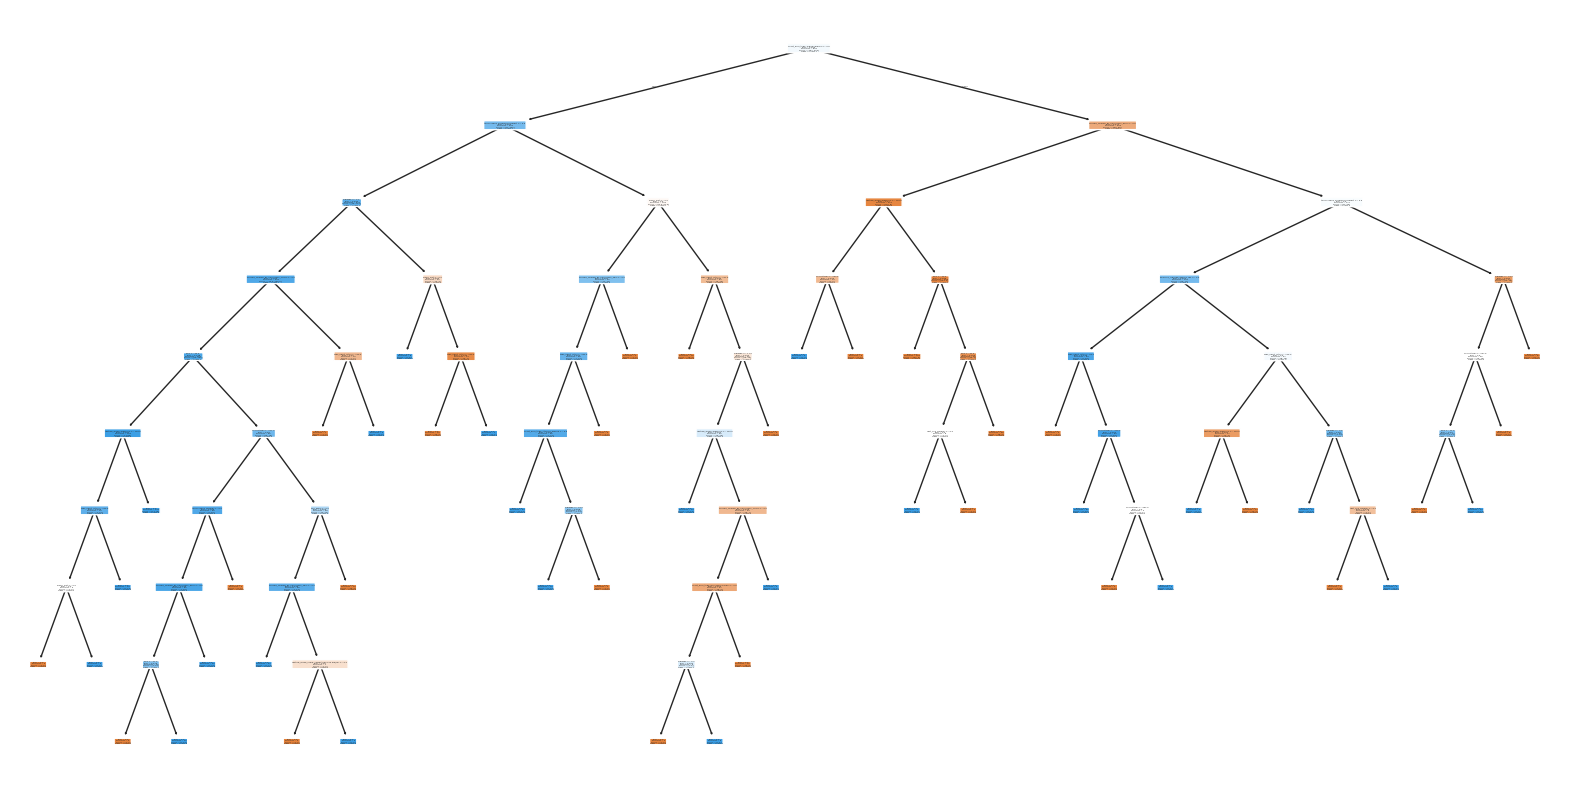

In [250]:
# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(model_OptimalTree, feature_names=X_train.columns, class_names=["Class 0", "Class 1"], filled=True, rounded=True)
plt.show()

In [251]:
# Export the decision tree rules as text
tree_rules = export_text(model_OptimalTree, feature_names=list(X_train.columns))
print(tree_rules)

|--- chest_pain_type_Typical angina <= 0.50
|   |--- thalassemia_Reversable Defect <= 0.50
|   |   |--- oldpeak <= 2.10
|   |   |   |--- vessels_colored_by_flourosopy_Three <= 0.50
|   |   |   |   |--- age <= 55.50
|   |   |   |   |   |--- resting_blood_pressure <= 109.00
|   |   |   |   |   |   |--- Max_heart_rate <= 159.50
|   |   |   |   |   |   |   |--- slope_Flat <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- slope_Flat >  0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Max_heart_rate >  159.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- resting_blood_pressure >  109.00
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- age >  55.50
|   |   |   |   |   |--- cholestoral <= 271.00
|   |   |   |   |   |   |--- thalassemia_Normal <= 0.50
|   |   |   |   |   |   |   |--- vessels_colored_by_flourosopy_Zero <= 0.50
|   |   |   |   |   |   |   |   |--- age <= 61.00
|   |   |   | 

In [252]:
# Make predictions on the test set
y_pred = model_OptimalTree.predict(X_test)
y_pred_proba = model_OptimalTree.predict_proba(X_test)[:, 1]  # Probabilities for class 1

In [253]:
# Use the custom score function for accuracy
accuracy = model_OptimalTree.score(X_test, y_test)

# Calculate other evaluation metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

Accuracy: 0.9854
F1 Score: 0.9852
Precision: 1.0000
Recall: 0.9709
AUC-ROC: 0.9854


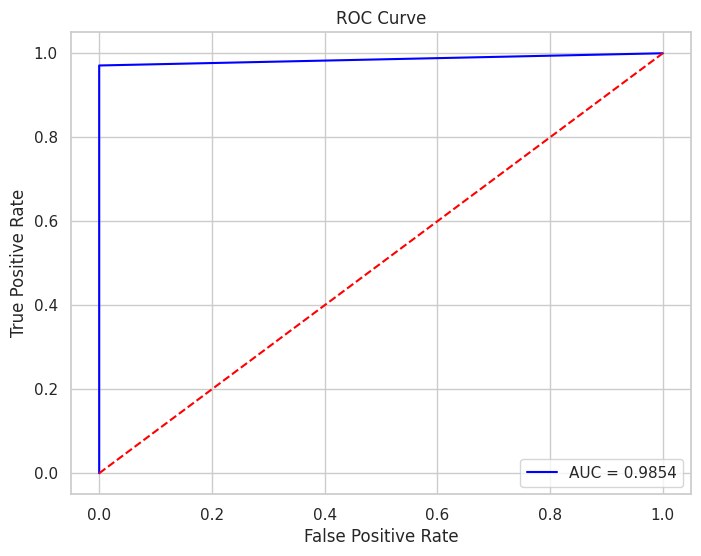

In [254]:
# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Visualize the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()